# 2. Logistic Regression

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
import sys

In [3]:
drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive/spotify/scripts/')
%cd /content/gdrive/MyDrive/spotify/scripts/

Mounted at /content/gdrive
/content/gdrive/MyDrive/spotify/scripts


In [7]:
df = pd.read_csv("../data/master_data.csv")
df['year'] = df['release_date'].apply(lambda x: int(x[:4]))
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

In [8]:
# Linear Regression
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score

x = df.loc[:,audio_features].values
y = df.loc[:,"popularity"].values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print(regressor.intercept_)
print(regressor.coef_)

y_pred = regressor.predict(X_test)
out_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.round(0)})
prediction_acc = np.where(out_df["Actual"] == out_df["Predicted"], True, False)
out_df["Correct"] = prediction_acc
print(out_df.head(1000))

acc = 100 * out_df["Correct"].sum()/ out_df.shape[0]
print(acc)


34.516418104078014
[ -3.93809917  10.25855845  -7.66680225  -5.89028116  -2.46213465
   0.80927195   1.34494452   0.01768107 -13.90929056]
     Actual  Predicted  Correct
0         0       12.0    False
1        17       24.0    False
2         0       24.0    False
3         7       13.0    False
4        45       24.0    False
..      ...        ...      ...
995      41       30.0    False
996      13       13.0     True
997      45       23.0    False
998      16       17.0    False
999      20       15.0    False

[1000 rows x 3 columns]
1.955160380515321


In [ ]:
!pip install vaderSentiment

In [ ]:
# Feature Engineering
# https://www.kaggle.com/pelinsoylu/spotify-popularity-prediction-ml-practice

# Hit or Not Hit
hit_cutoff = 50

df['hit?'] = df['popularity'].apply(lambda x: 1 if x>=hit_cutoff else 0)
print(df['hit?'].value_counts(normalize=True))
hit_class_weight = float(df['hit?'].value_counts(normalize=True)[0])
# For a cut off of 50 only ~9% of our tracks are hits, will need to account for 
# imbalanced dataset when training.

# Sentiment analysis of track title using VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
df['sentiment'] = df['name'].apply(lambda x: analyser.polarity_scores(x)['compound'])

cut_bins = [-1, -0.33, 0.33, 1]
cut_labels = ["negative", "neutral", "postive"]
df['polarity'] = pd.cut(df['sentiment'], bins=cut_bins, labels=cut_labels)

0    0.919817
1    0.080183
Name: hit?, dtype: float64


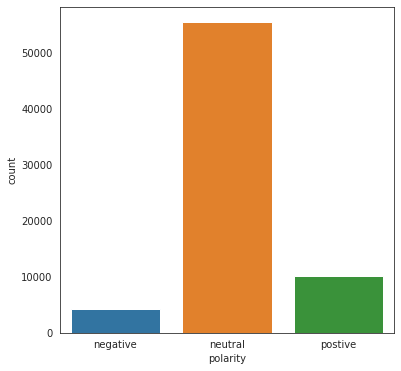

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(x='polarity', data=df)
plt.show()

In [ ]:
# Check for nulls before training
df.columns[df.isnull().any()]

Index([], dtype='object')

In [ ]:
x = df.drop(["artist_name", "album", "name", "track_number", "release_date", "year", "id", "uri", "polarity", "hit?", "popularity"], axis=1)
y = df.loc[:,"hit?"].values
print(x.head())

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

   acousticness  danceability  energy  ...    tempo  valence  sentiment
0         0.337         0.754   0.352  ...   74.017    0.754     0.0000
1         0.188         0.652   0.472  ...   81.966    0.750     0.0000
2         0.650         0.594   0.494  ...  134.083    0.440     0.0000
3         0.912         0.267   0.177  ...   80.824    0.201     0.0000
4         0.311         0.737   0.295  ...   70.952    0.701     0.0772

[5 rows x 10 columns]


https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [ ]:
def conf_matrix(y_test, pred_test):    

    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.show()

Class Weight: None
Model Accuracy: 99.66%
F1 Score: 0.0


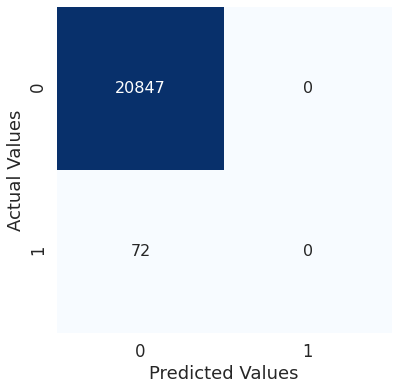


Class Weight: balanced
Model Accuracy: 68.55%
F1 Score: 0.01732377538829152


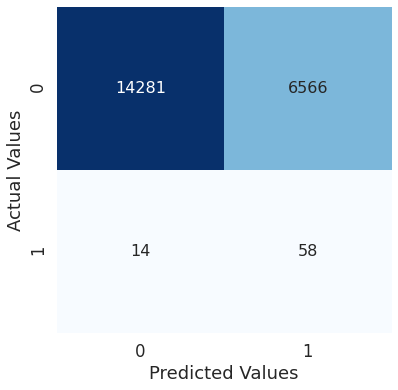


Class Weight: {0: 0.08018299678751717, 1: 0.9198170032124828}
Model Accuracy: 99.66%
F1 Score: 0.0


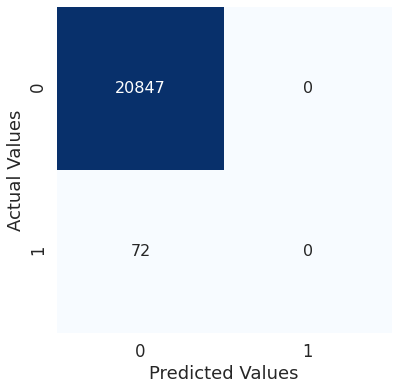

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score

class_perc = {0: 1 - hit_class_weight, 1: hit_class_weight}

def LogisiticRegressionModel(X_train, X_test, y_train, y_test, class_weight):
  model = LogisticRegression(solver="newton-cg", class_weight = class_weight, dual = False)
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  acc = model.score(X_test, y_test)
  return model, predictions, acc

for class_weight in ["None", "balanced", class_perc]:
  print(f"Class Weight: {class_weight}")
  model, predictions, acc = LogisiticRegressionModel(X_train, X_test, y_train, y_test, class_weight)
  print(f"Model Accuracy: {round(100*acc,2)}%")
  print(f"F1 Score: {f1_score(y_test, predictions)}")
  conf_matrix(y_test, predictions)
  print()

Setting the class weight is integral to ensuring that our algorithm is learning to fit to the data. I have presented the confusion matrices for threee cases above:

1. No class weighting: Assigns an equal class weighting. Examining the confusion matrix we can see that the model is simple assigning every prediction the score of 0 (i.e. not hit), as indicated by the high accuracy, but low f1 score of the model.

2. Balanced class weighting: This has improved our f1-score, but significantly decreased the accuracy of the album

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   20.5s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed:  5.6min
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:  8.7min finished
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Scoring for different class weights')

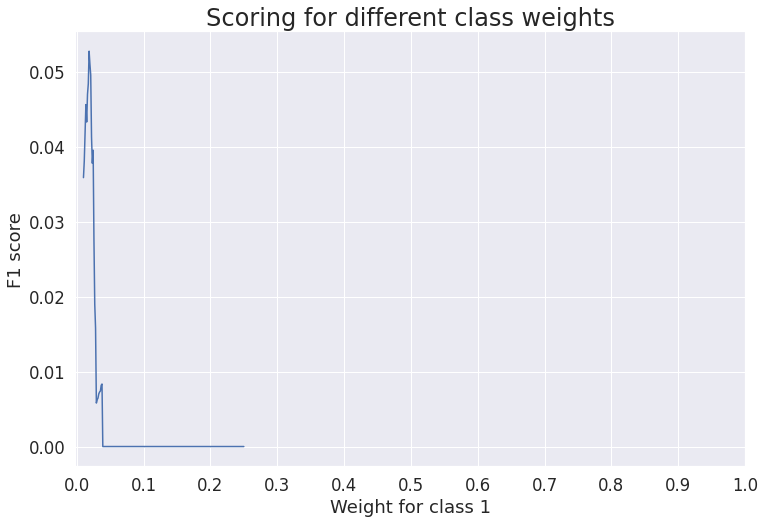

In [ ]:
# Grid Search for optimum weighting
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = LogisticRegression(solver='newton-cg')
weights = np.linspace(0.75,0.99,200)
param_grid = {'class_weight': [{1:x, 0:1.0-x} for x in weights]}
gridsearch = GridSearchCV(estimator=model, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=2, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 0')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)


In [ ]:
max_f1_score = weigh_data['score'].max()

print(weigh_data[weigh_data['score']==0.05271347476522993])

        score    weight
192  0.052713  0.018442


Model Accuracy: 97.65%
F1 Score: 0.0390625


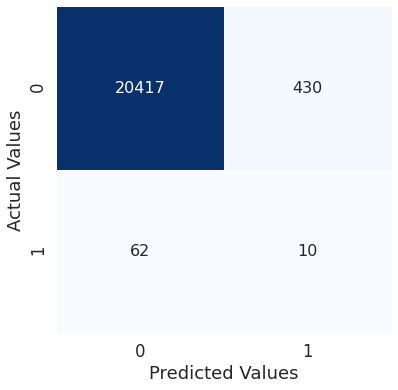

In [ ]:
optimum_weight = {0: 0.018442, 1: 1-0.018442}
model, predictions, acc = LogisiticRegressionModel(X_train, X_test, y_train, y_test, optimum_weight)

print(f"Model Accuracy: {round(100*acc,2)}%")
print(f"F1 Score: {f1_score(y_test, predictions)}")
conf_matrix(y_test, predictions)